# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [4]:
# Load pickled data
import pickle
import os

training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file =  'traffic-signs-data/test.p'
training_transformed = 'traffic-signs-data/train_transformed.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# Load transformed data if it exists
transformedDataLoaded = False
if os.path.exists(training_transformed):
    transformedDataLoaded = True
    with open(training_transformed, mode = 'rb') as f:
        train_transformed = pickle.load(f)
    
X_train, Y_train = train['features'], train['labels']
X_valid, Y_valid = valid['features'], valid['labels']
X_test, Y_test = test['features'], test['labels']
print('Data Loaded')

Data Loaded


---

## Step 1: Data Set Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Data Set Summary

In [5]:
import numpy as np

n_train = X_train.shape[0]

n_valid = X_valid.shape[0]

n_test = X_test.shape[0]

image_shape = X_train[1].shape

n_classes = np.unique(Y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory Visualization of the Data Set

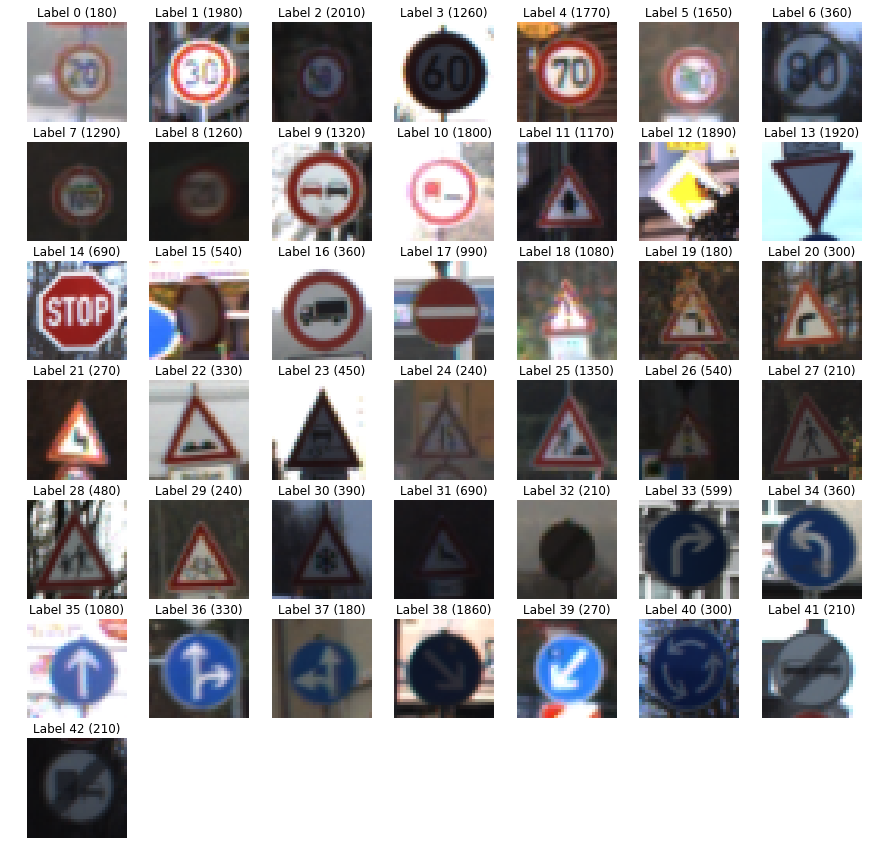

In [6]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import random

# Print random image from each class
unique_labels, counts = np.unique(Y_train, return_counts=True)
plt.figure(figsize=(15,15))
i=1
for label,count in zip(unique_labels,counts):
    signs_ThisLabel = X_train[np.array(Y_train == unique_labels[label])]
    image = signs_ThisLabel[random.randint(0,len(signs_ThisLabel))-1]
    plt.subplot(7,7,i)
    plt.axis('off')
    plt.title("Label {0} ({1})".format(label, count))
    plt.imshow(image)
    plt.axis('off')
    i+=1
plt.show()

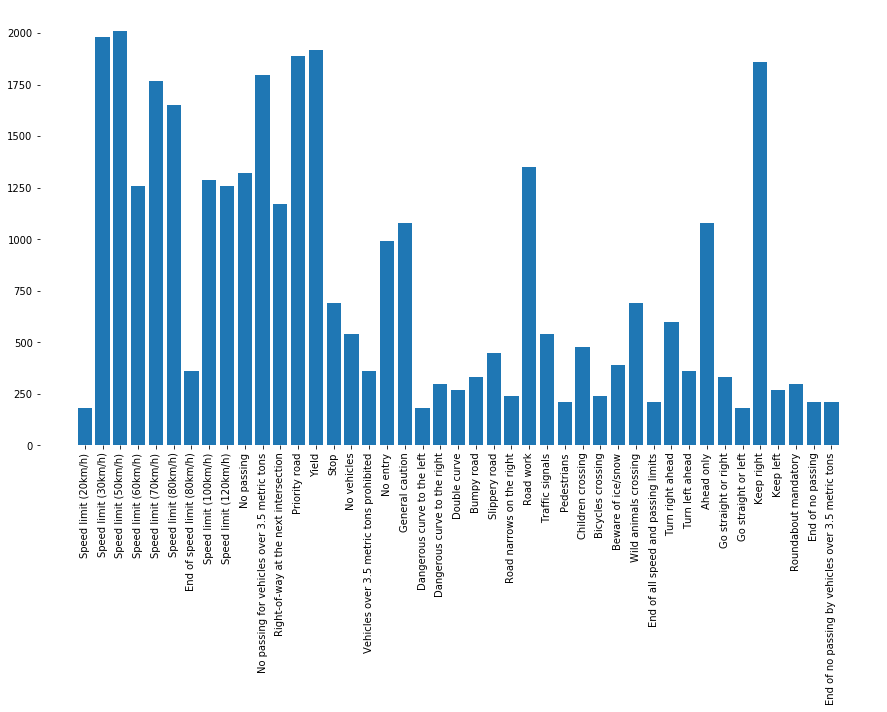

In [7]:
import csv
labels, label_counts = np.unique(train['labels'], return_counts=True)
ClassID = []
SignName = []
with open('signnames.csv') as file:
    signnames = csv.reader(file, delimiter=',')
    for row in signnames:
        ClassID.append(row[0])
        SignName.append(row[1])
ClassID = ClassID[1:]
SignName = SignName[1:]
# for Sign, label_count in zip(SignName, label_counts):
#     print('{}: {}'.format(Sign, str(label_count)))
plt.figure(figsize=(15,8))
plt.bar(range(len(labels)), label_counts)
plt.box('off')
plt.xticks(range(len(SignName)), SignName, rotation=90);


----

## Step 2: Design and Test a Model Architecture

### Data Preprocessing

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [8]:
from sklearn.utils import shuffle
import math
import tensorflow as tf
import cv2
import scipy.ndimage.interpolation as ndimage

In [9]:
print('Size Of Dataset')
print(X_train.shape)

Size Of Dataset
(34799, 32, 32, 3)


Transformed Data Loaded


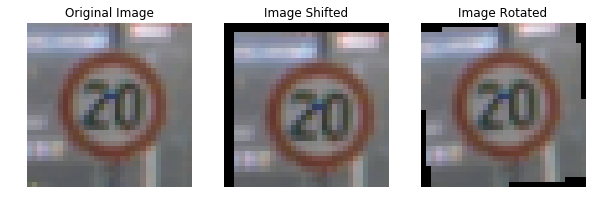

In [10]:
if transformedDataLoaded:
    X_train, Y_train = train_transformed['features'], train_transformed['labels']
    print('Transformed Data Loaded')
else:
    
    # Number of samples per class
    Num_Samples_Per_Class = np.bincount(Y_train)
    # Largest number of samples
    Max_Num_Samples = np.max(Num_Samples_Per_Class)
    # Get all of the classes
    Classes = np.unique(Y_train)
    # Threshold for classes to have image transforms
    threshold = Max_Num_Samples*0.5
    print('Transforming....')

    # For each class
    for Class in Classes:
        # If the number of sample sufficient dont do any transforms
        if Num_Samples_Per_Class[Class] > threshold:
            continue

        # Calcuate the number of transformations to do to get the samples to the right amount
        # Limit the number transformations to the total number of transformations available so we dont get doubles
        Num_transformations = int(round(Max_Num_Samples/Num_Samples_Per_Class[Class]) - 1)

        print('Class: {} | Transformations: {} | Current Samples: {}| Finished Samples: {}'\
              .format(Class, Num_transformations, Num_Samples_Per_Class[Class], Num_Samples_Per_Class[Class]*Num_transformations))
        # Array to store transformed images. So it doesn't tranform already transformed images on the next loop
        transformed_images = []
        transformed_labels = []
        for i in range(Num_transformations):
            # Apply a transform to each image of that class
            for image in X_train[np.where(Y_train == Class)]:
                # Randomly select the transformation (0=rotation, 1=translation)
                if random.choice([True, False]):
                    # rotate the image by a random amount
                    transformed_images.append(ndimage.rotate(image, random.randrange(-5,5), reshape=False))
                    transformed_labels.append(Class)
                else:
                    # translate the image by a random amount
                    transformed_images.append(ndimage.shift(image, [random.uniform(-2,2),random.uniform(-2,2),0]))
                    transformed_labels.append(Class)

        X_train = np.append(X_train, np.array(transformed_images), axis=0)
        Y_train = np.append(Y_train, np.array(transformed_labels), axis=0)

    print('Finished Transformations')
    print(X_train.shape)

    # Arrange data and save to file
    train_transformed = {'features': X_train, 'labels': Y_train}
    with open(training_transformed, mode='wb') as f:
        pickle.dump(train_transformed, f)

        
test_image = X_train[10000]
plt.figure(figsize=[10,10])
plt.subplot(1,3,1)
plt.imshow(test_image)
plt.axis('off')
plt.title('Original Image');
plt.subplot(1,3,2)
plt.imshow(ndimage.shift(test_image,[2,2,0]))
plt.axis('off')
plt.title('Image Shifted');
plt.subplot(1,3,3)
plt.imshow(ndimage.rotate(test_image,5, reshape=False))
plt.axis('off')
plt.title('Image Rotated');

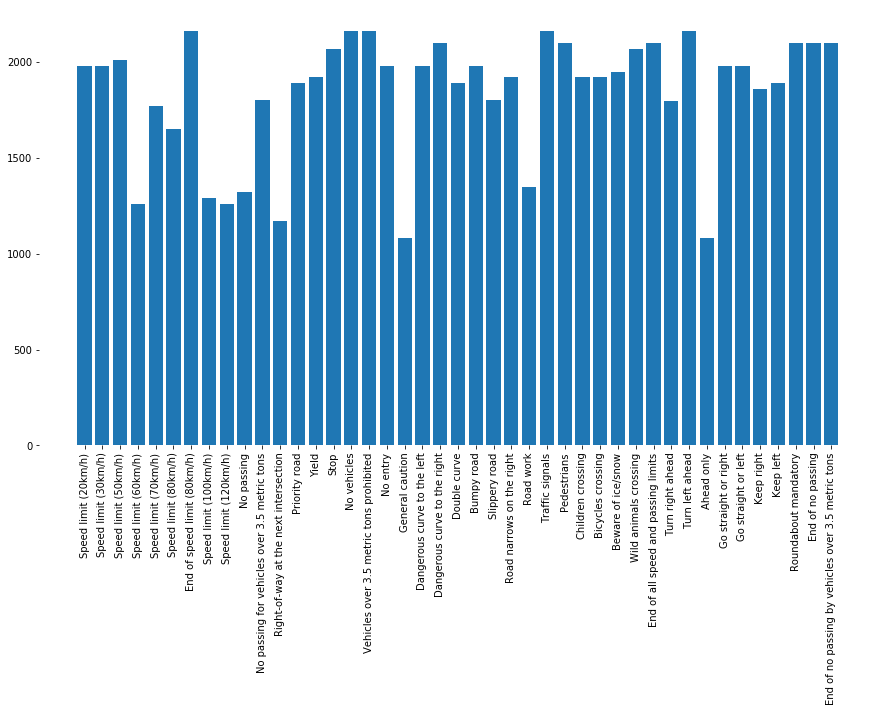

In [11]:
plt.figure(figsize=(15,8))
plt.bar(range(len(labels)), np.bincount(Y_train))
plt.box('off')
plt.xticks(range(len(SignName)), SignName, rotation=90);

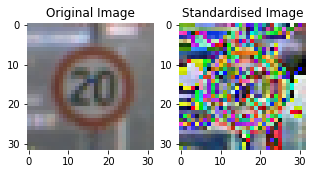

In [12]:
# Standardise each image about its mean and standard deviation
def ImageStandardisation(image):
    image_mean = np.mean(image)
    image_StdDev = max(np.std(image), 1.0/math.sqrt(image.size))
    return (image - image_mean)/image_StdDev

X_train = np.array([ImageStandardisation(image) for image in X_train])
X_valid = np.array([ImageStandardisation(image) for image in X_valid])
X_test = np.array([ImageStandardisation(image) for image in X_test])

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(test_image)
plt.box('off')
plt.title('Original Image');
plt.subplot(1,2,2)
plt.imshow(X_train[10000])
plt.box('off')
plt.title('Standardised Image');

In [14]:
# Shuffle the data to prevent any influence of order
X_train, Y_train = shuffle(X_train, Y_train)

### Model Architecture

In [15]:
# Import Librarys
from tensorflow.contrib.layers import flatten

In [16]:
# Select Hyperparameters
EPOCHS = 20
BATCH_SIZE = 128 
LEARNING_RATE = 0.001

In [17]:
# Function for convolution
def conv2d(x, W, b, name, stride=1):
    x = tf.nn.conv2d(x, W, strides=[1,stride,stride,1], padding='VALID')
    x = tf.nn.bias_add(x,b, name=name)
    x = BatchNormalisation(x)
    return tf.nn.relu(x)

In [18]:
# Function for Max Pooling
def maxpool(x, k, name):
    ksize = [1,2,2,1]
    strides = [1,2,2,1]
    return tf.nn.max_pool(x, ksize, strides, padding='VALID', name=name)

In [19]:
def fullyConnected(x, W, b, name):
    x = tf.add(tf.matmul(x, W),b, name=name)
    x = BatchNormalisation(x, axes=[0])
    return tf.nn.relu(x)

In [20]:
epsilon = 1e-3
def BatchNormalisation(inputs, axes=[0,1,2]):
    scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
    beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
    
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)
    
    return tf.cond(is_training, lambda: BN_training(inputs, pop_mean, pop_var, beta, scale, axes), 
                   lambda: BN_testing(inputs, pop_mean, pop_var, beta, scale))

def BN_training(inputs, pop_mean, pop_var, beta, scale, axes, decay=0.999):
    batch_mean, batch_var = tf.nn.moments(inputs, axes)
    train_mean = tf.assign(pop_mean, pop_mean*decay+batch_mean*(1-decay))
    train_var = tf.assign(pop_var, pop_var*decay+batch_var*(1-decay))
    with tf.control_dependencies([train_mean, train_var]):
        return tf.nn.batch_normalization(inputs, batch_mean, batch_var, beta, scale, epsilon)

def BN_testing(inputs, pop_mean, pop_var, beta, scale):
    return tf.nn.batch_normalization(inputs, pop_mean, pop_var, beta, scale, epsilon)

In [21]:
# Function for the Architecture
def CNN_Architecture(x):
    # Mean and StdDev for randominsation
    mu = 0
    sigma = 0.1
    
    weights = {
        'wc1' : tf.Variable(tf.truncated_normal(shape=(5,5,3,6), mean = mu, stddev = sigma)),
        'wc2' : tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean = mu, stddev = sigma)),
        'wfc1': tf.Variable(tf.truncated_normal(shape=(400,120), mean = mu, stddev = sigma)),
        'wfc2': tf.Variable(tf.truncated_normal(shape=(120,84), mean = mu, stddev = sigma)),
        'out' : tf.Variable(tf.truncated_normal(shape=(84,n_classes), mean = mu, stddev = sigma))
    }
    biases = {
        'bc1' : tf.Variable(tf.zeros(6)),
        'bc2' : tf.Variable(tf.zeros(16)),
        'bfc1': tf.Variable(tf.zeros(120)),
        'bfc2': tf.Variable(tf.zeros(84)),
        'out' : tf.Variable(tf.zeros(n_classes)),
    }
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6
    conv1 = conv2d(x, weights['wc1'], biases['bc1'], name='conv1')
    
    # Layer 1: Pooling. Input = 28x28x6. Output = 14x14x6.
    pool1 = maxpool(conv1, 2, name='pool1')
    
    # Layer 2: Convolutional. Output = 10x10x16. 
    conv2 = conv2d(pool1, weights['wc2'], biases['bc2'], name='conv2')
    
    # Layer 2: Pooling. Input = 10x10x16. Output = 5x5x16. 
    pool2 = maxpool(conv2, 2, name='pool2')
    
    # Flatten. Input = 5x5x16. Output = 400.
    flat = flatten(pool2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = fullyConnected(flat, weights['wfc1'], biases['bfc1'], name='fc1')
    
    # Dropout
    drop1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = fullyConnected(drop1, weights['wfc2'], biases['bfc2'], name='fc2')
    
    # Dropout
    drop2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(drop2,weights['out']), biases['out'])
    
    return logits

### Model Training, Validating and Testing

In [22]:
# x,y placeholders
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool)
one_hot_y = tf.one_hot(y, n_classes)

In [23]:
# Training Pipeline

# Get logits from the CNN
logits = CNN_Architecture(x)

# Use Cross Entropy and Softmax to find differences between 
# predictions and labels
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)

# Calculate the loss
loss_operation = tf.reduce_mean(cross_entropy)

# Minimise the loss by optmising the weights
optimiser = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
training_operation = optimiser.minimize(loss_operation)

In [26]:
# Model Evaluation

# Get the prediction
label_prediction = tf.arg_max(logits, 1)

# Get the correct predictions
correct_prediction = tf.equal(label_prediction, tf.arg_max(one_hot_y,1))

# Calculate the accuracy of the model
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Create a saver to save the model
saver = tf.train.Saver()

def evaluate(X_data, Y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    predictions = np.array([])
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], Y_data[offset:offset+BATCH_SIZE]
        accuracy, prediction, loss = sess.run([accuracy_operation, label_prediction, loss_operation], 
                                        feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, is_training: False})
        total_accuracy += (accuracy * len(batch_x))
        predictions = np.append(predictions, prediction)
    return total_accuracy / num_examples, predictions, loss

In [29]:
# Train the model
# Record the accuracy to asses fitting
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

saveFile = './SavedModel/TrafficSign_CNN.ckpt'

import time
# Start a session to run the trainning in
with tf.Session() as sess:
    # Initialise all of the variables
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    max_trainAccuracy = 0
    max_validAccuracy = 0
    
    start_time_total = time.time()
    print("Training...")
    print()
    
    for i in range(EPOCHS):
        start_time_epoch = time.time()
        # Shuffle data each epoch to reduce over fitting
        X_train, Y_train = shuffle(X_train, Y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], Y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5, is_training: True})
        
        # Get the Accuracy of the model from the epoch using the validation data
        train_acc, _, train_loss = evaluate(X_train,Y_train)
        training_accuracy.append(train_acc)
        training_loss.append(train_loss)
        valid_acc, _, valid_loss = evaluate(X_valid, Y_valid)
        validation_accuracy.append(valid_acc)
        validation_loss.append(valid_loss)
        
        print("EPOCH {} ...".format(i+1))
        print("Train Acc = {:.3f}    Valid Acc = {:.3f}    Train Loss = {:.3f}    Valid Loss = {:.3f}"
              .format(training_accuracy[-1], validation_accuracy[-1], training_loss[-1], validation_loss[-1]))
        print('Epoch Training Time: {:.3f} sec'.format(time.time() - start_time_epoch))
        print()
        
        # Save the model to file if it has the higher accuracy than the previous iterations
        # Dont save oif both are equal, this wmodel would be overfitted
        if (train_acc >= max_trainAccuracy and valid_acc > max_validAccuracy) or \
            (train_acc > max_trainAccuracy and valid_acc >= max_validAccuracy):
                saver.save(sess, saveFile)
                print('Model Saved')
                print()
                max_trainAccuracy = train_acc
                max_validAccuracy = valid_acc
    
    print('Total Training Time: {:.3f}'.format(time.time() - start_time_total))
    

Training...

EPOCH 1 ...
Train Acc = 0.876    Valid Acc = 0.822    Train Loss = 0.751    Valid Loss = 0.922
Epoch Training Time: 109.656 sec

Model Saved

EPOCH 2 ...
Train Acc = 0.959    Valid Acc = 0.899    Train Loss = 0.256    Valid Loss = 0.276
Epoch Training Time: 112.778 sec

Model Saved

EPOCH 3 ...
Train Acc = 0.978    Valid Acc = 0.932    Train Loss = 0.125    Valid Loss = 0.252
Epoch Training Time: 113.510 sec

Model Saved

EPOCH 4 ...
Train Acc = 0.984    Valid Acc = 0.938    Train Loss = 0.063    Valid Loss = 0.472
Epoch Training Time: 113.877 sec

Model Saved

EPOCH 5 ...
Train Acc = 0.988    Valid Acc = 0.952    Train Loss = 0.018    Valid Loss = 0.216
Epoch Training Time: 116.037 sec

Model Saved

EPOCH 6 ...
Train Acc = 0.990    Valid Acc = 0.949    Train Loss = 0.006    Valid Loss = 0.305
Epoch Training Time: 114.887 sec

EPOCH 7 ...
Train Acc = 0.993    Valid Acc = 0.966    Train Loss = 0.052    Valid Loss = 0.221
Epoch Training Time: 118.688 sec

Model Saved

EPOCH 

### Model Evaluation

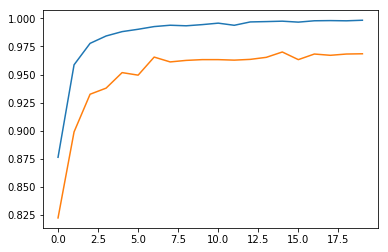

<function matplotlib.pyplot.grid>

In [31]:
plt.figure
plt.hold
plt.plot(range(0,EPOCHS), training_accuracy)
plt.plot(range(0,EPOCHS), validation_accuracy)
plt.show()
plt.grid

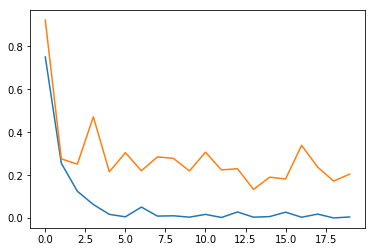

In [33]:
plt.plot(range(0,EPOCHS), training_loss)
plt.plot(range(0,EPOCHS), validation_loss)
plt.show()

In [99]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(y_valid, y_predicted, title):
    cm = confusion_matrix(y_true=y_valid, y_pred=y_predicted)
    
    maxValue=0
    maxValue = max([(max(maxValue, cm[i,j])) for i in range(cm.shape[0]) for j in range(cm.shape[1]) if i!=j])
    for i,j in zip(range(n_classes), range(n_classes)):
            cm[i,j]=maxValue
    # Done to provide some contrast on graph to easily see the ones with errors
    cm[np.where(cm==0)] = -10
    
    # Plot the figure
    plt.figure(figsize=(10,10))
    plt.imshow(cm, cmap='Blues')
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, range(n_classes))
    plt.yticks(tick_marks, range(n_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Plot the numbers on th graph
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i,j] > 0 and i!=j:
            plt.text(j, i, cm[i,j], horizontalalignment='center',
                    color='black')
    plt.tight_layout()
    plt.box('off')
    plt.title(title)
    plt.savefig('{}.png'.format(title[0:-33]))
    plt.show()

Training Classification Accuracy: 99.75%
Validation Classification Accuracy: 97.01%


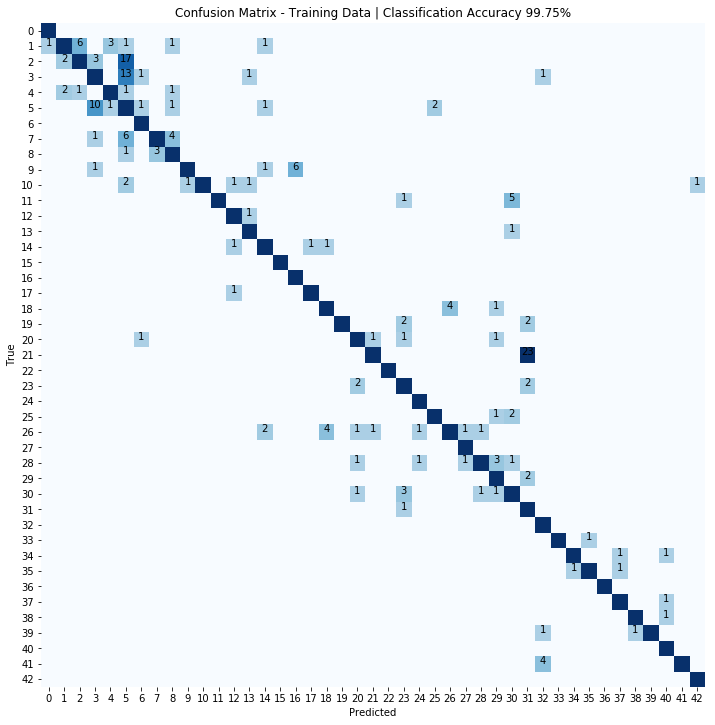

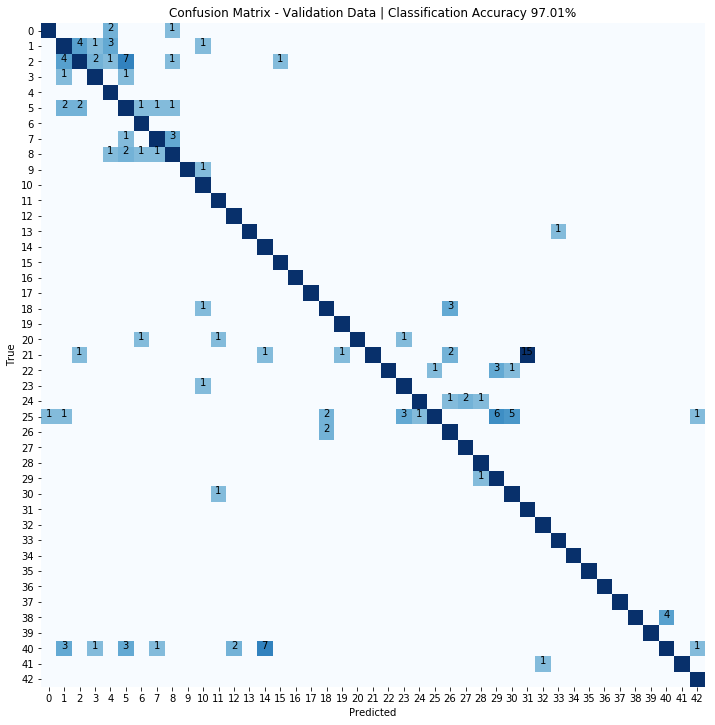

In [100]:
# Load Current model and plot the confusion matrix
with tf.Session() as sess:
    saver.restore(sess, saveFile)
    [validation_accuracy_train, y_pred_train,_] = evaluate(X_train, Y_train)
    print('Training Classification Accuracy: {:.4}%'.format(validation_accuracy_train*100))
    [validation_accuracy_valid, y_pred_valid,_] = evaluate(X_valid, Y_valid)
    print('Validation Classification Accuracy: {:.4}%'.format(validation_accuracy_valid*100))

plot_confusion_matrix(Y_train, y_pred_train, 
                      'Confusion Matrix - Training Data | Classification Accuracy {:.4}%'.format(validation_accuracy_train*100))
plot_confusion_matrix(Y_valid, y_pred_valid, 
                      'Confusion Matrix - Validation Data | Classification Accuracy {:.4}%'.format(validation_accuracy_valid*100))    

In [35]:
# Load current model and get the testing accuracy
with tf.Session() as sess:
    saver.restore(sess, saveFile)
    [test_accuracy, y_pred,_] = evaluate(X_test, Y_test)
    print('Test Accuracy: {:.3f}'.format(test_accuracy))

Test Accuracy: 0.948


---

## Step 3: Test a Model on New Images

### Choosen Images

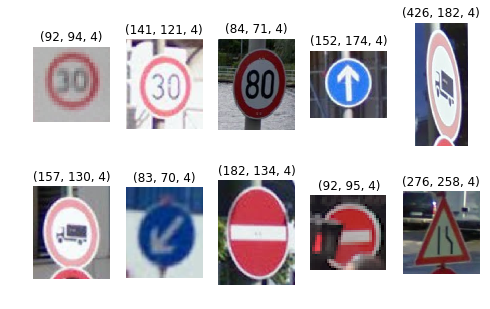

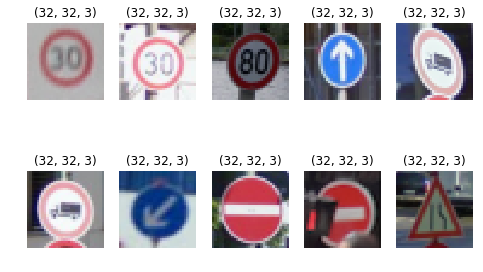

In [55]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
image_dir = './TestImages/'

#Load the images
TestImages = np.array([plt.imread(image_dir+image) for image in os.listdir(image_dir)])
plt.figure(figsize=(8,5))
for i, image in enumerate(TestImages):
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(image.shape)

# Convert all images to RGB from RGBA
TestImages = [cv2.cvtColor(image, cv2.COLOR_RGBA2RGB) for image in TestImages]

# Resize all of the images to 32x32x3
TestImages = [cv2.resize(image, dsize=(32,32), interpolation=cv2.INTER_AREA) for image in TestImages]
plt.figure(figsize=(8,5))
for i, image in enumerate(TestImages):
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(image.shape)

TestImages_Labels = np.array([1,1,5,35,16,16,39,17,17,24])

In [56]:
# Standardise each image about its mean and standard deviation
def ImageStandardisation(image):
    image_mean = np.mean(image)
    image_StdDev = max(np.std(image), 1.0/math.sqrt(image.size))
    return (image - image_mean)/image_StdDev

TestImages_Std = np.array([ImageStandardisation(image) for image in TestImages])

### Model Predictions

Test Image Accuracy = 100.0%


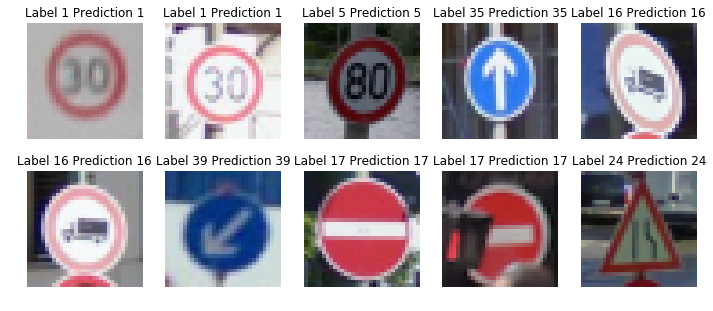

In [68]:
with tf.Session() as sess:
    saver.restore(sess, saveFile)
    accuracy,label_pred,_ = evaluate(TestImages_Std, TestImages_Labels)

print('Test Image Accuracy = {:.1f}%'.format(accuracy*100))
plt.figure(figsize=(12,5))
for i, (image, label, pred) in enumerate(zip(TestImages, TestImages_Labels, label_pred)):
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Label {:.0f} Prediction {:.0f}'.format(label, pred))

### Softmax Probabilities

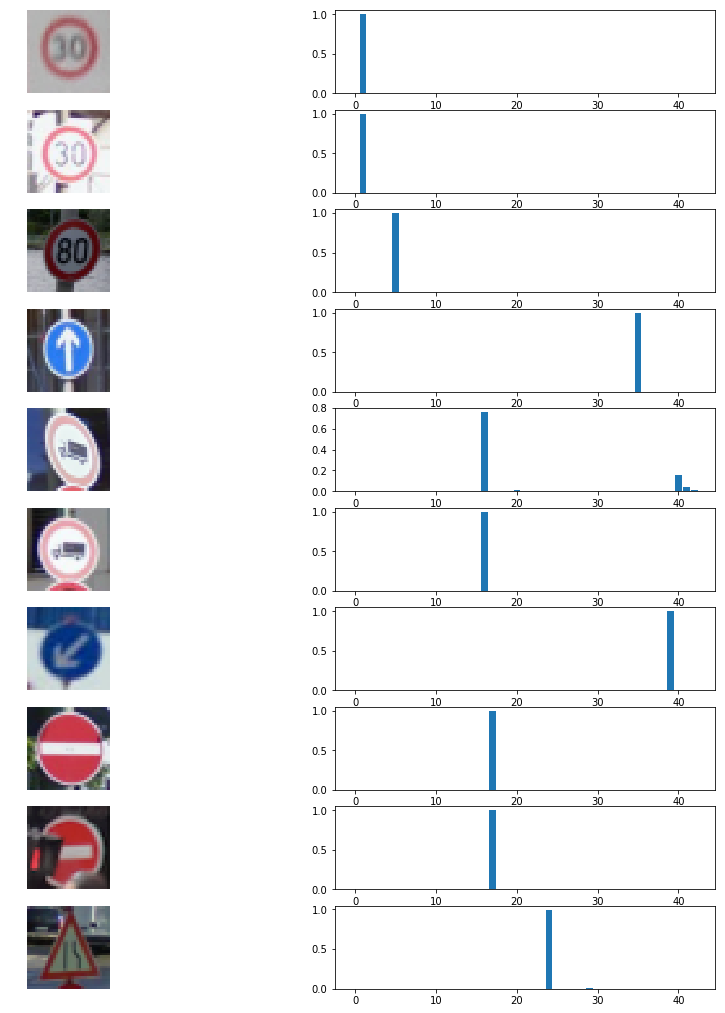

In [82]:
softmax = tf.nn.top_k(tf.nn.softmax(logits), k=43)
with tf.Session() as sess:
    saver.restore(sess, saveFile)
    top_k = sess.run(softmax, feed_dict={x:TestImages_Std, keep_prob:1.0, is_training:False})

plt.figure(figsize=(15,18))
for i, image, indices, values in zip(range(0,20,2), TestImages, top_k.indices, top_k.values):
    plt.subplot(10,2,i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(10,2,i+2)
    plt.bar(indices,values)

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [89]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, is_training: False})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
    plt.show()

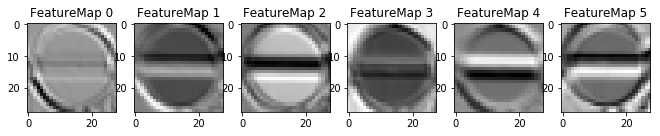

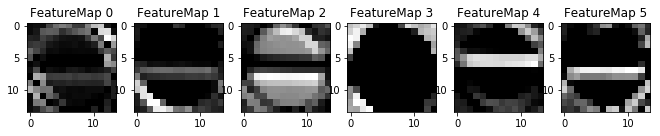

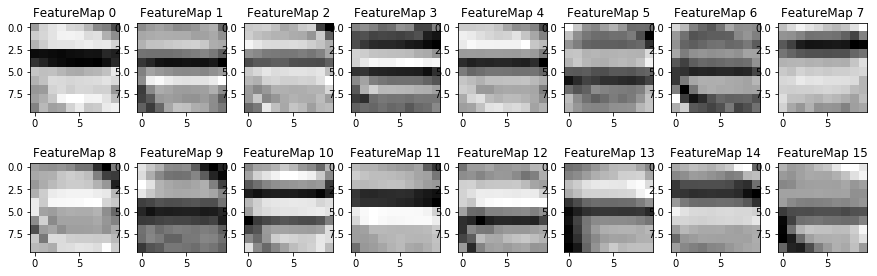

In [94]:
with tf.Session() as sess:
    saver.restore(sess, saveFile)
    conv1 = tf.get_default_graph().get_tensor_by_name('conv1:0')
    outputFeatureMap([TestImages_Std[7]], conv1)
    pool1 = tf.get_default_graph().get_tensor_by_name('pool1:0')
    outputFeatureMap([TestImages_Std[7]], pool1)
    conv2 = tf.get_default_graph().get_tensor_by_name('conv2:0')
    outputFeatureMap([TestImages_Std[7]], conv2)

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**
Passing the images through the feature map produces some very interesting results and does provide some insight to what each layer is doing. I tried passing various images through the feature map to get a better understanding and found that i could continue to see features in the seconds convolutional layer using the No Entry sign

The first convolutional layer appears to be picking up the outside white ring and perhaps its edge as well as different parts of the horizontal white line.

The pooling layer then looks to be reducing the resolution of the image down. Kind of doubling down on what it found in the previous image

The second convolutional layer is much harder to determine what is going on. It kind of looks as though the filter is moving the white line up and down in the image perhaps to account for rotation and translation of the image. Other than that it is hard to determine what it is looking for

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 